In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        #model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step, doc_term_matrix,dictionary):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_json("7postElection.json")
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
data["vaderScore"] = scores


In [3]:
#prova a togliere retweet
data = data[data["is_retweet"] == False]

data.rename(index=str, columns={"year": "date_year"},inplace=True)
data.rename(index=str, columns={"month": "date_month"},inplace=True)

data.drop(["hour","in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,date_month,date_year,week_year,labels,vaderScore
favorite_count,1.000000,0.891237,-0.164023,0.185635,-0.164811,0.076417,-0.098971
retweet_count,0.891237,1.000000,-0.089613,0.144045,-0.090638,0.090506,-0.166127
date_month,-0.164023,-0.089613,1.000000,-0.302847,0.984279,-0.032168,0.064430
date_year,0.185635,0.144045,-0.302847,1.000000,-0.302369,0.021680,-0.019233
week_year,-0.164811,-0.090638,0.984279,-0.302369,1.000000,-0.034066,0.066510
labels,0.076417,0.090506,-0.032168,0.021680,-0.034066,1.000000,-0.129911
vaderScore,-0.098971,-0.166127,0.064430,-0.019233,0.066510,-0.129911,1.000000


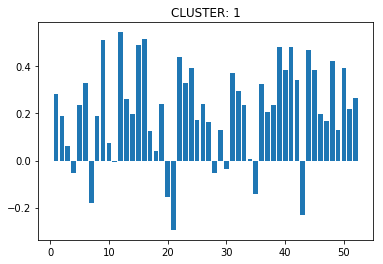

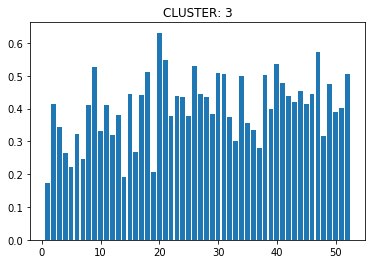

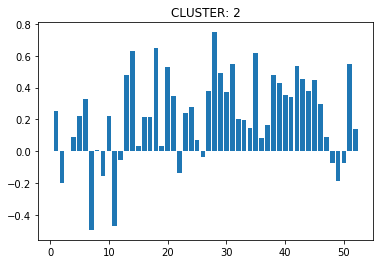

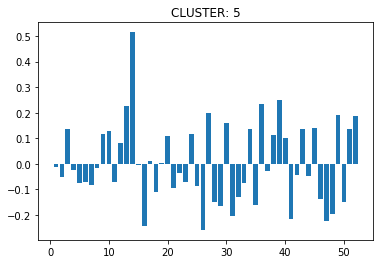

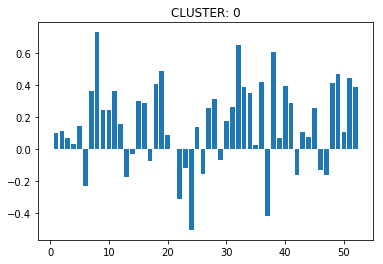

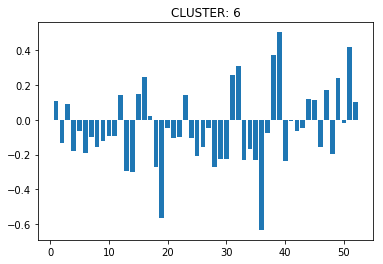

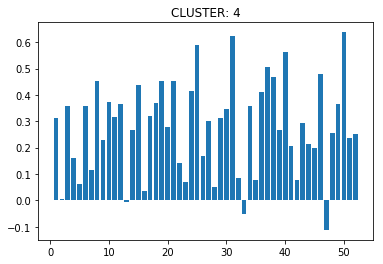

In [4]:
for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.bar(time.index, time )
    plt.show()


In [5]:
x1 = data[data["labels"] == 2]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  

stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]
x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

514


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([2.663e+03, 6.400e+01, 2.000e+01, 1.200e+01, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([   4. ,  150.7,  297.4,  444.1,  590.8,  737.5,  884.2, 1030.9,
        1177.6, 1324.3, 1471. ]),
 <a list of 10 Patch objects>)

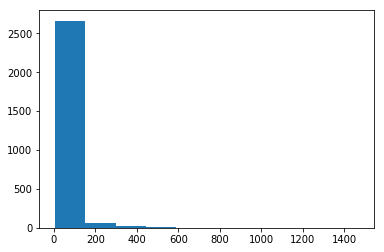

In [6]:
plt.hist(stemmed_words)

In [7]:
x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!! sembra che il tempo peggiori sse e migliori silhouette
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
#dataWithText = res
res1.columns

Index(['date_year', 'week_year', 'vaderScore', '100', '1000', '1100', '11th',
       '12', '13', '14',
       ...
       'xi', 'ye', 'year', 'yesterday', 'yet', 'york', 'young', 'your', 'zero',
       'zone'],
      dtype='object', length=1764)

# Hierarchical

In [ ]:
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

sil = []
for c in range(10,22):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(res1, 'average', "cosine")


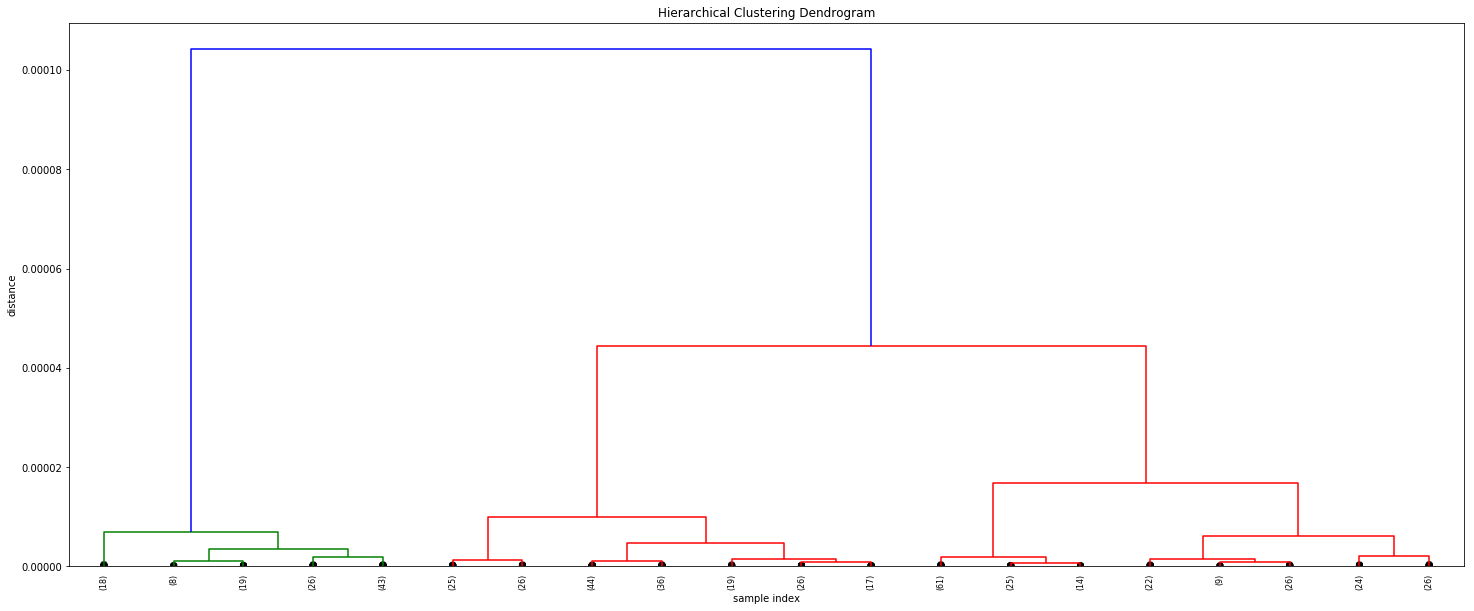

In [9]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()


In [21]:
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
print(res1.columns)
clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=12) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_
d = silhouette_score(res1, labels,metric='cosine')
print(d)

Index(['date_year', 'week_year', 'vaderScore', '100', '1000', '1100', '11th',
       '12', '13', '14',
       ...
       'xi', 'ye', 'year', 'yesterday', 'yet', 'york', 'young', 'your', 'zero',
       'zone'],
      dtype='object', length=1764)
0.6210486537567742


# LDA

In [22]:
res1["labels"] = labels
dataWithText["labels"] = labels
g = res1.drop(["vaderScore"],axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster  5  lunghezza  18
NUMBER OF TOPICS FOR CLUSTER  5  :  1


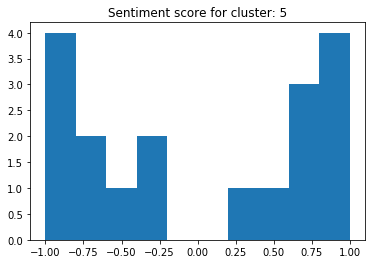

[2017, 2019]
numero di settimane in cluster 3
anni nel cluster  2


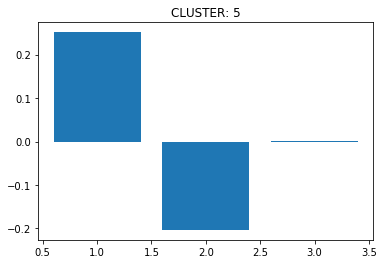

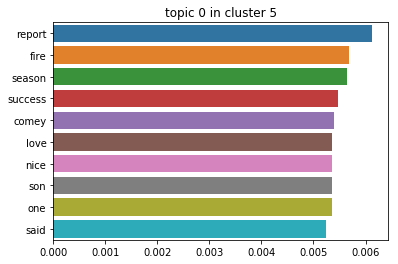

['chicago', 'murder', 'rate', 'record', 'set', 'shoot', 'victim', 'murder', '2016', 'mayor', 'cant', 'must', 'ask', 'feder', 'help']
[(0, 1.0)]
cluster  11  lunghezza  26
NUMBER OF TOPICS FOR CLUSTER  11  :  1


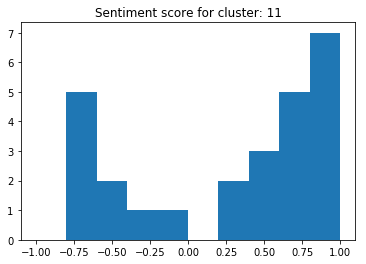

[2017, 2018, 2019]
numero di settimane in cluster 4
anni nel cluster  2


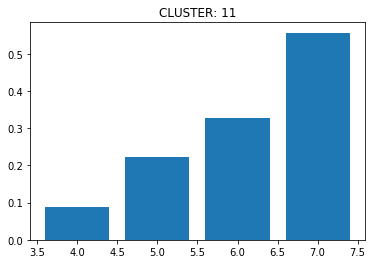

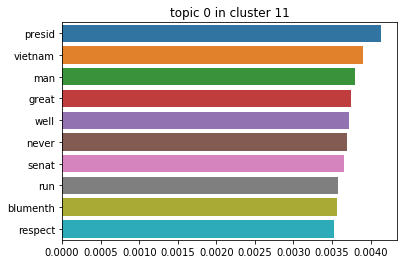

['hope', 'like', 'nomin', 'judg', 'gorsuch', 'unit', 'state', 'suprem', 'court', 'good', 'brilliant', 'man', 'respect']
[(0, 1.0)]
cluster  6  lunghezza  43
NUMBER OF TOPICS FOR CLUSTER  6  :  3


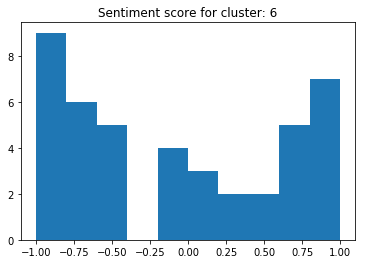

[2017, 2018, 2019]
numero di settimane in cluster 4
anni nel cluster  2


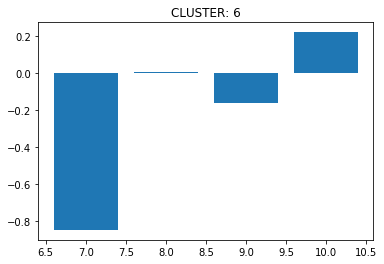

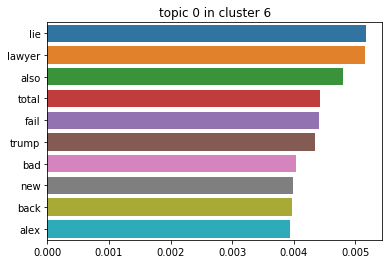

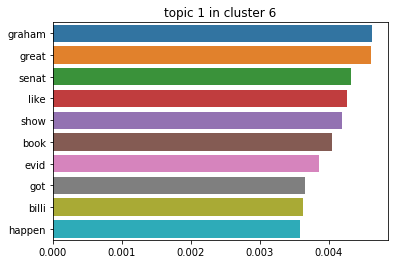

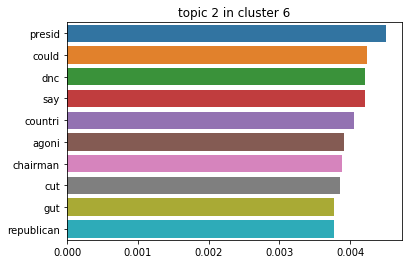

['one', 'thing', 'say', 'rep', 'keith', 'fight', 'lead', 'dnc', 'one', 'predict', 'earli', 'would', 'win']
[(0, 0.080377), (1, 0.07970558), (2, 0.83991736)]
cluster  3  lunghezza  27
NUMBER OF TOPICS FOR CLUSTER  3  :  3


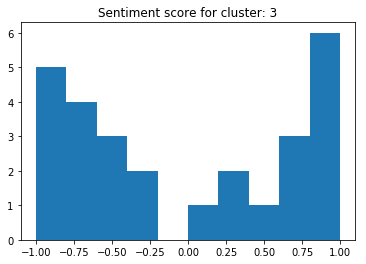

[2017, 2018, 2019]
numero di settimane in cluster 4
anni nel cluster  5


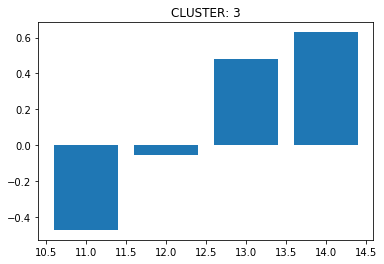

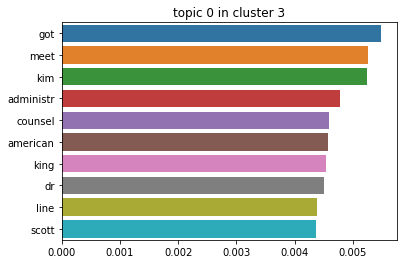

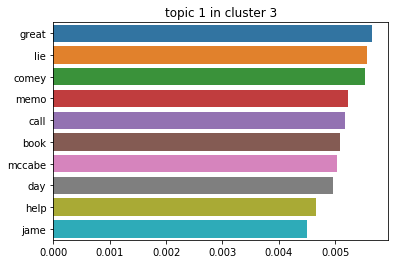

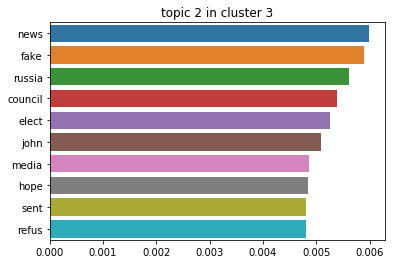

['anybodi', 'realli', 'believ', 'report', 'nobodi', 'ever', 'heard', 'went', 'found', 'tax', 'return', 'nbcnew', 'fake', 'news']
[(0, 0.074619256), (1, 0.07501995), (2, 0.8503608)]
cluster  8  lunghezza  26
NUMBER OF TOPICS FOR CLUSTER  8  :  4


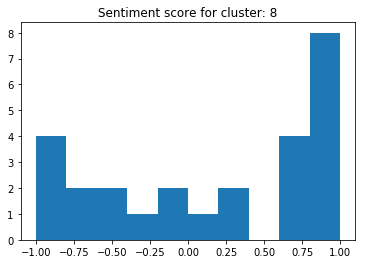

[2017, 2018]
numero di settimane in cluster 3
anni nel cluster  3


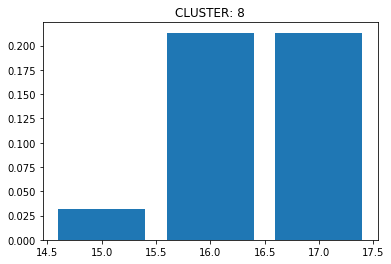

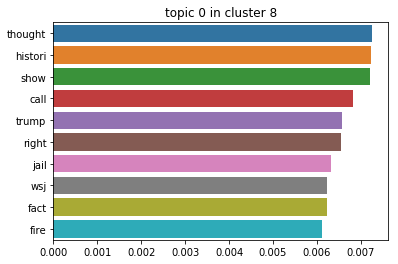

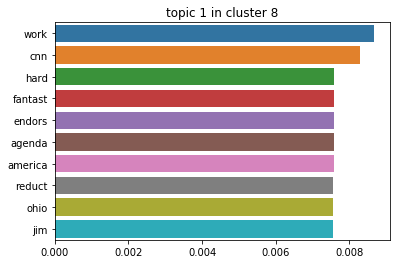

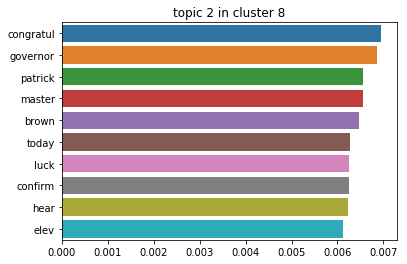

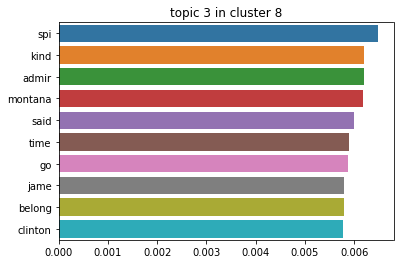

['congratul', 'justic', 'gorsuch', 'elev', 'unit', 'state', 'suprem', 'court', 'great', 'day']
[(0, 0.06283107), (1, 0.06302229), (2, 0.8108363), (3, 0.063310295)]
cluster  9  lunghezza  24
NUMBER OF TOPICS FOR CLUSTER  9  :  5


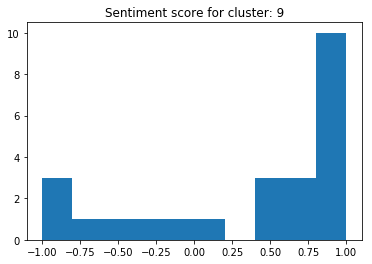

[2017, 2018]
numero di settimane in cluster 4
anni nel cluster  3


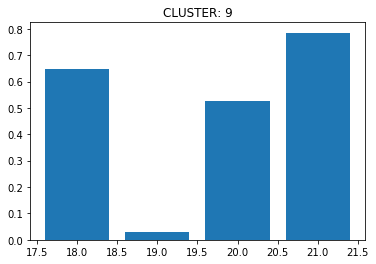

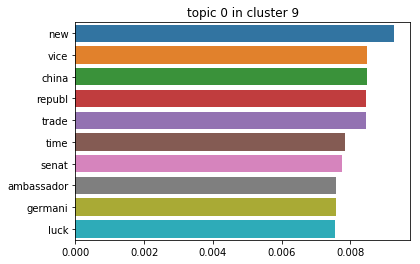

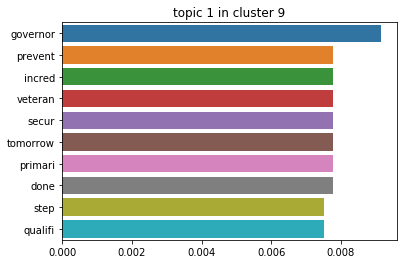

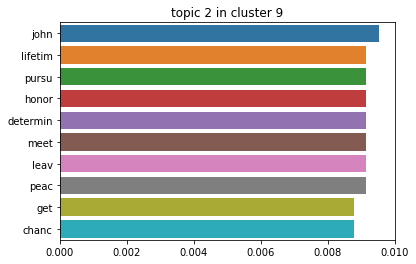

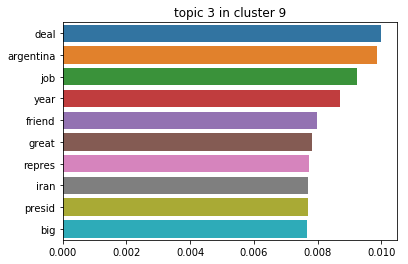

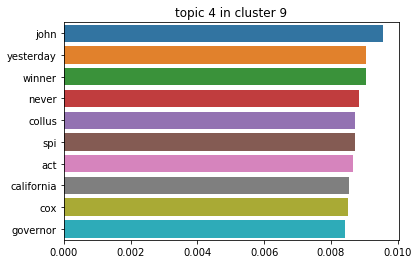

['fbi', 'director', 'comey', 'best', 'thing', 'ever', 'happen', 'hillari', 'clinton', 'gave', 'free', 'pass', 'mani', 'bad', 'phoni']
[(0, 0.04180732), (1, 0.04174956), (2, 0.041845996), (3, 0.83252823), (4, 0.04206892)]
cluster  2  lunghezza  57
NUMBER OF TOPICS FOR CLUSTER  2  :  2


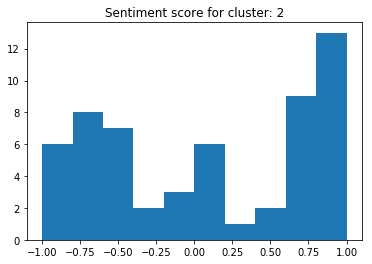

[2017, 2018]
numero di settimane in cluster 7
anni nel cluster  6


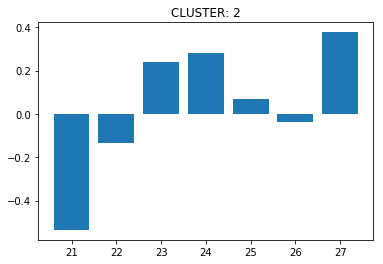

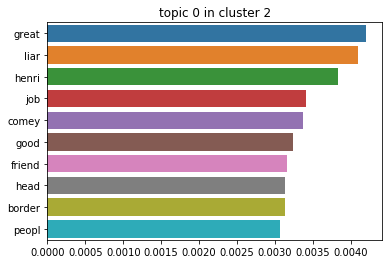

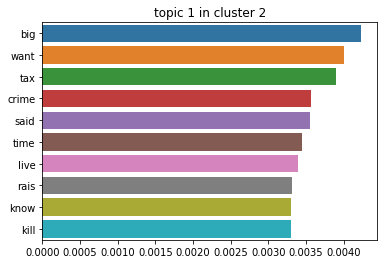

['report', 'democrat', 'carter', 'page', 'russia', 'dont', 'want', 'testifi', 'blow', 'away']
[(0, 0.7466792), (1, 0.2533208)]
cluster  4  lunghezza  39
NUMBER OF TOPICS FOR CLUSTER  4  :  1


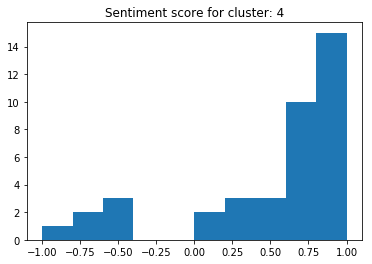

[2017, 2018]
numero di settimane in cluster 4
anni nel cluster  1


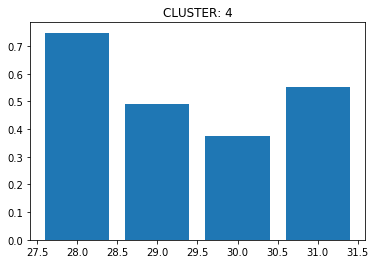

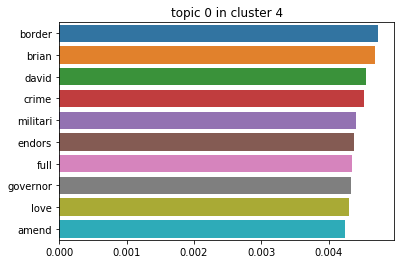

['son', 'donald', 'interview', 'seanhann', 'tonight', '1000', 'pm', 'great', 'person', 'love', 'countri']
[(0, 1.0)]
cluster  10  lunghezza  61
NUMBER OF TOPICS FOR CLUSTER  10  :  3


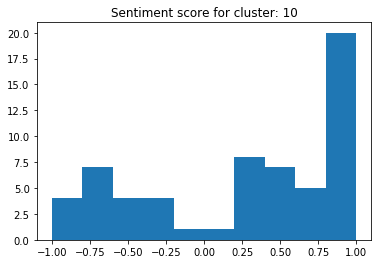

[2017, 2018]
numero di settimane in cluster 4
anni nel cluster  5


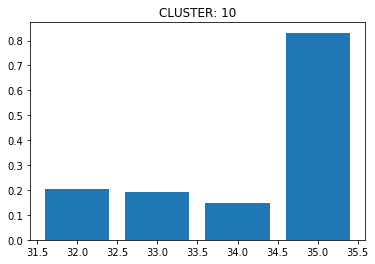

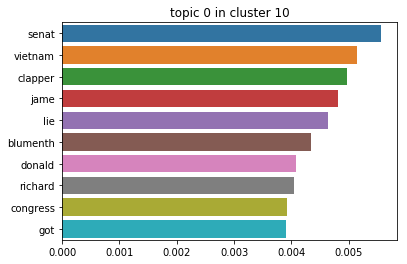

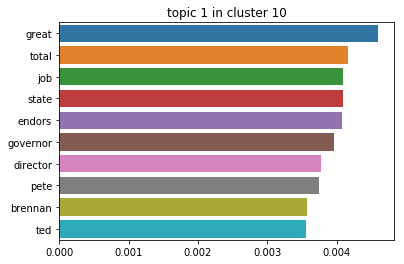

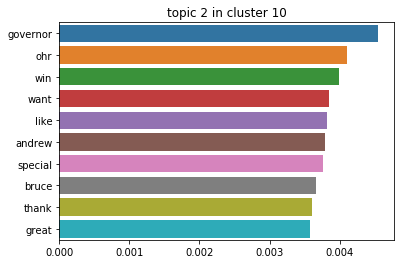

['interest', 'watch', 'senat', 'richard', 'blumenth', 'connecticut', 'talk', 'hoax', 'russian', 'collus', 'phoni', 'vietnam', 'con']
[(0, 0.84763765), (1, 0.076397255), (2, 0.07596506)]
cluster  0  lunghezza  62
NUMBER OF TOPICS FOR CLUSTER  0  :  4


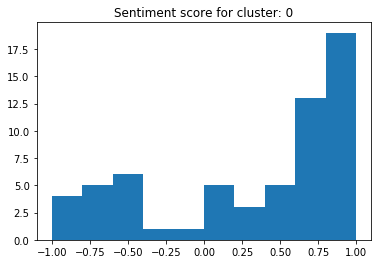

[2017, 2018]
numero di settimane in cluster 7
anni nel cluster  4


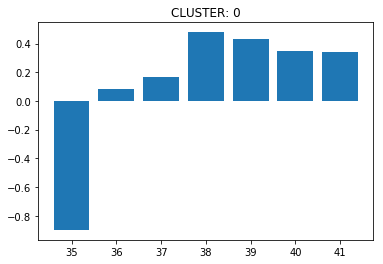

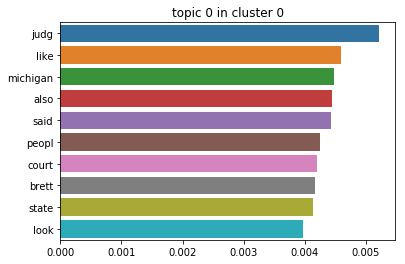

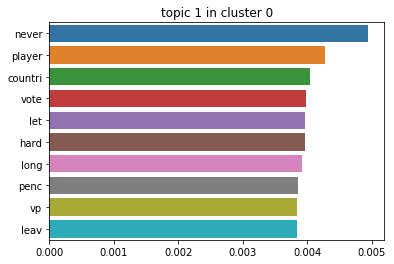

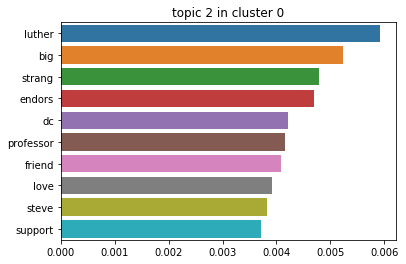

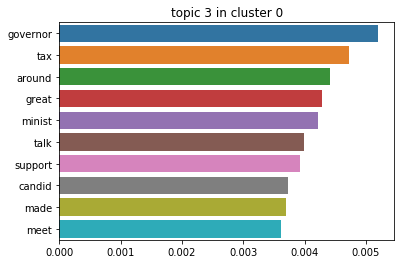

['heed', 'advic', 'your', 'evacu', 'zone', 'need', 'get', 'mani', 'hour', 'left', 'gov', 'scott']
[(0, 0.057059687), (1, 0.058147233), (2, 0.8271584), (3, 0.05763466)]
cluster  7  lunghezza  80
NUMBER OF TOPICS FOR CLUSTER  7  :  3


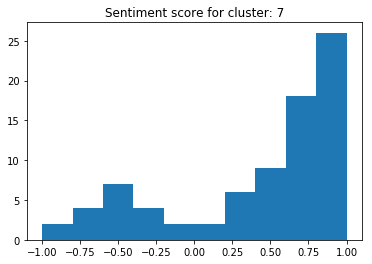

[2017, 2018]
numero di settimane in cluster 6
anni nel cluster  3


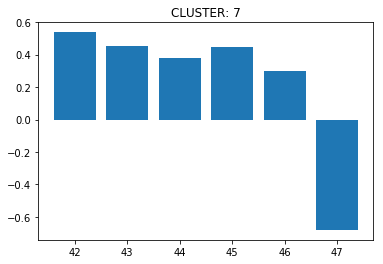

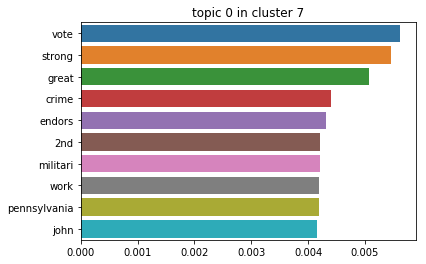

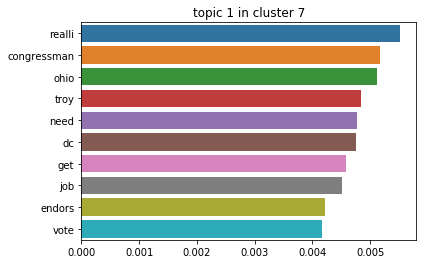

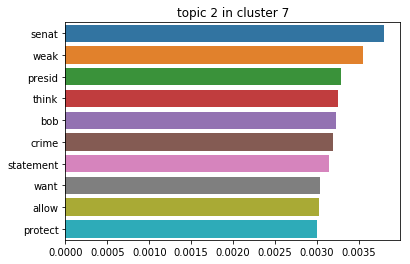

['dem', 'senat', 'schumer', 'hate', 'iran', 'deal', 'made', 'presid', 'obama', 'involv', 'ok', 'tell', 'israel', 'chuck']
[(0, 0.07481543), (1, 0.076384746), (2, 0.8487998)]
cluster  1  lunghezza  51
NUMBER OF TOPICS FOR CLUSTER  1  :  4


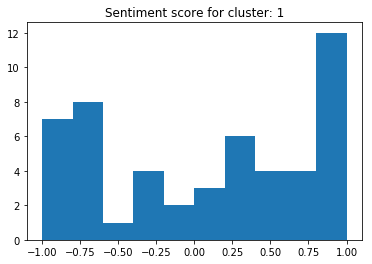

[2017, 2018]
numero di settimane in cluster 6
anni nel cluster  7


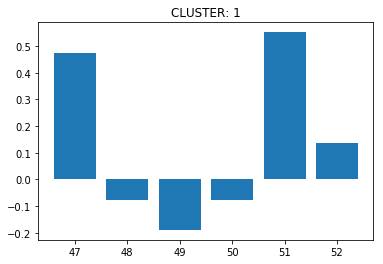

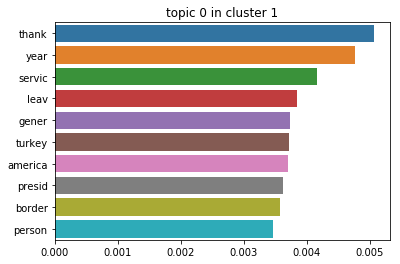

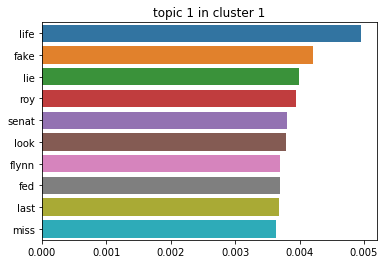

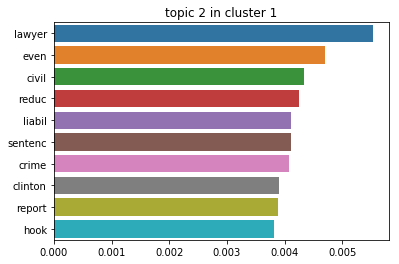

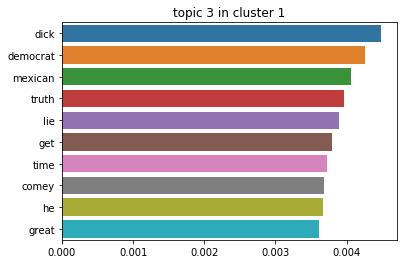

['confer', 'board', 'said', 'consum', 'highest', 'level', 'nearli', '17', 'year', 'novemb', 'consum', 'confid', 'index', 'rose', 'octob', 'best', 'read', 'sinc', 'decemb', '2000']
[(0, 0.854677), (1, 0.04849578), (2, 0.048426367), (3, 0.04840079)]


In [23]:

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))
        
        from gensim.corpora.dictionary import Dictionary

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        
        common_dictionary = Dictionary(corp)
        common_corpus = [common_dictionary.doc2bow(text) for text in corp]
        tfidf = TfidfModel(common_corpus)
        tfidf_corpus = tfidf[common_corpus]


        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step,tfidf_corpus,common_dictionary)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)

        lda = LdaModel(tfidf_corpus, num_topics=nTopics, id2word=common_dictionary)

        
        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        print(d1["date_year"].unique().tolist())
        print("numero di settimane in cluster", len(d1["week_year"].unique().tolist()))
        print("anni nel cluster ", len(g1["year"].unique().tolist()))
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster))
        plt.bar(time.index, time )
        plt.show()

        topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False,log=True)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.001:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            sns.barplot(x=weights, y=words)
            plt.show()        
        vector = lda.get_document_topics(tfidf_corpus[0])
        print(corp[0])
        print(vector)

# kmeans

In [ ]:
res1 = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 


In [ ]:
res1.columns

In [ ]:
%%time
sse_list = list()
max_k = 40
plt.figure(figsize=(18,6))
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(res1)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list)
plt.show()

In [ ]:
#i cluster sembrano suddividere in settimane consecutive 

true_k =5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(res1)
print(model.inertia_)
print
labels = model.labels_
res1["labels"] = labels
dataWithText["labels"] = labels
d = silhouette_score(res1, labels,metric='euclidean')
print(d)

In [ ]:
g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))
        
        from gensim.corpora.dictionary import Dictionary

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        
        common_dictionary = Dictionary(corp)
        common_corpus = [common_dictionary.doc2bow(text) for text in corp]
        tfidf = TfidfModel(common_corpus)
        tfidf_corpus = tfidf[common_corpus]


        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step,tfidf_corpus,common_dictionary)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)

        lda = LdaModel(tfidf_corpus, num_topics=nTopics, id2word=common_dictionary)

        
        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        print(d1["date_year"].unique().tolist())
        print("numero di settimane in cluster", len(d1["week_year"].unique().tolist()))
        print("anni nel cluster ", len(g1["year"].unique().tolist()))
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster))
        plt.bar(time.index, time )
        plt.show()

        topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False,log=True)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.001:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            sns.barplot(x=weights, y=words)
            plt.show()        
        vector = lda.get_document_topics(tfidf_corpus[0])
        print(corp[0])
        print(vector)